# Padded Graph Matching
Consider the scenario where one would like to match graphs $A$ and $B$ with $n_1$ and $n_2$ nodes, respectively, where 
$n_1 < n_2$. The most straightforward fashion to 'pad' $A$, such that $A$ and $B$ have the same shape, is to add $n_2 - n_1$ isolated nodes to $A$ (represented as empty row/columns in the adjacency matrix). This padding scheme is known as $\textit{naive padding}$, substituting $A \oplus 0_{(n_2-n_1)x(n_2-n_1)}$ and $B$ in place of $A$ and $B$, respectively.

The effect of this is that one matches $A$ to the best subgraph of $B$. That is, the isolated vertices added to $A$ through padding have an affinity to the low-density subgraphs of $B$, in effect giving the isolates a false signal.  

Instead, we may desire to match $A$ to the best fitting induced subgraph of $B$. This padding scheme is known as $\textit{adopted padding}$, and is achieved by substituting $\tilde{A} \oplus 0_{(n_2-n_1)x(n_2-n_1)}$ and $\tilde{B}$ in place of $A$ and $B$, respectively, where $\tilde{A} = 2A - 1_{n_1}1_{n_1}^T$ and $\tilde{B} = 2B - 1_{n_2}1_{n_2}^T$.


To demonstrate the difference between the two padding schemes, we sample two graph's $G_1$ and $G_2'$, each having 400 vertices, from a $0.5 \sim SBM(4,b,\Lambda)$, where b assigns 100 vertices to each of the k = 4 blocks, and

\begin{align*}
\Lambda &= \begin{bmatrix} 
0.9 & 0.4 & 0.3 & 0.2\\
0.4 & 0.9 & 0.4 & 0.3\\
0.3 & 0.4 & 0.9 & 0.4\\
0.2 & 0.3 & 0.4 & 0.7
\end{bmatrix}\\
\end{align*}

We create $G_2$ from $G_2'$ by removing 25 nodes from each block of $G_2'$, yielding a 300 node graph (example adapted from section 2.5 of [1]).

The goal of the matching in this case is to recover $G_2$ by matching the right most figure below and $G_1$. That is, we seek to recover the shared community structure common between two graphs of differing shapes.

<a id="1">[1]</a> 
D. Fishkind, S. Adali, H. Patsolic, L. Meng, D. Singh, V. Lyzinski, C. Priebe,
        "Seeded graph matching", Pattern Recognit. 87 (2019) 203–215

## SBM correlated graph pairs

/home/runner/.cache/pypoetry/virtualenvs/graspologic-pkHfzCJ8-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


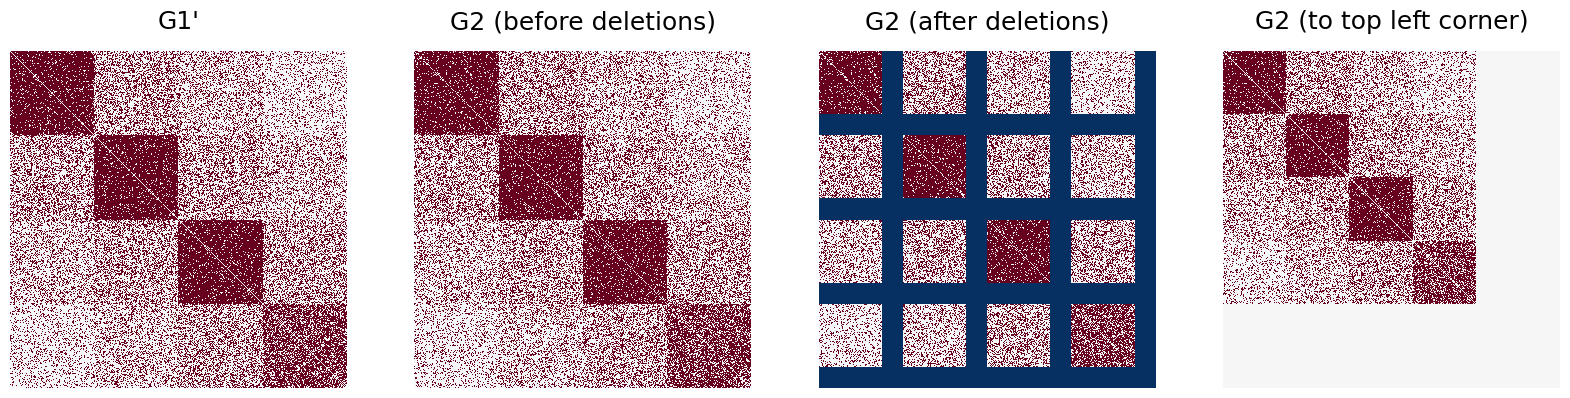

In [1]:
# simulating G1', G2, deleting 25 vertices
import numpy as np
import matplotlib.pyplot as plt
from graspologic.match import graph_match
from graspologic.simulations import sbm_corr
from graspologic.plot import heatmap

np.random.seed(1)
rng = np.random.default_rng(1)

directed = False
loops = False
block_probs = [
    [0.9, 0.4, 0.3, 0.2],
    [0.4, 0.9, 0.4, 0.3],
    [0.3, 0.4, 0.9, 0.4],
    [0.2, 0.3, 0.4, 0.7],
]
n = 100
n_blocks = 4
rho = 0.5
block_members = np.array(n_blocks * [n])
n_verts = block_members.sum()
G1, G2_full = sbm_corr(block_members, block_probs, rho, directed, loops)

keep_indices = np.concatenate(
    (np.arange(75), np.arange(100, 175), np.arange(200, 275), np.arange(300, 375))
)

G2 = G2_full[keep_indices][:, keep_indices]

G2_deleted = np.full((G1.shape), -1)
G2_deleted[np.ix_(keep_indices, keep_indices)] = G2

topleft_G2 = np.zeros((400, 400))
topleft_G2[:300, :300] = G2
fig, axs = plt.subplots(1, 4, figsize=(20, 10))
heatmap(G1, ax=axs[0], cbar=False, title="G1'")
heatmap(G2_full, ax=axs[1], cbar=False, title="G2 (before deletions)")
heatmap(G2_deleted, ax=axs[2], cbar=False, title="G2 (after deletions)")
_ = heatmap(topleft_G2, ax=axs[3], cbar=False, title="G2 (to top left corner)")

## Naive vs Adopted Padding

Matching accuracy with naive padding: 0.02
Matching accuracy with adopted padding: 1.00


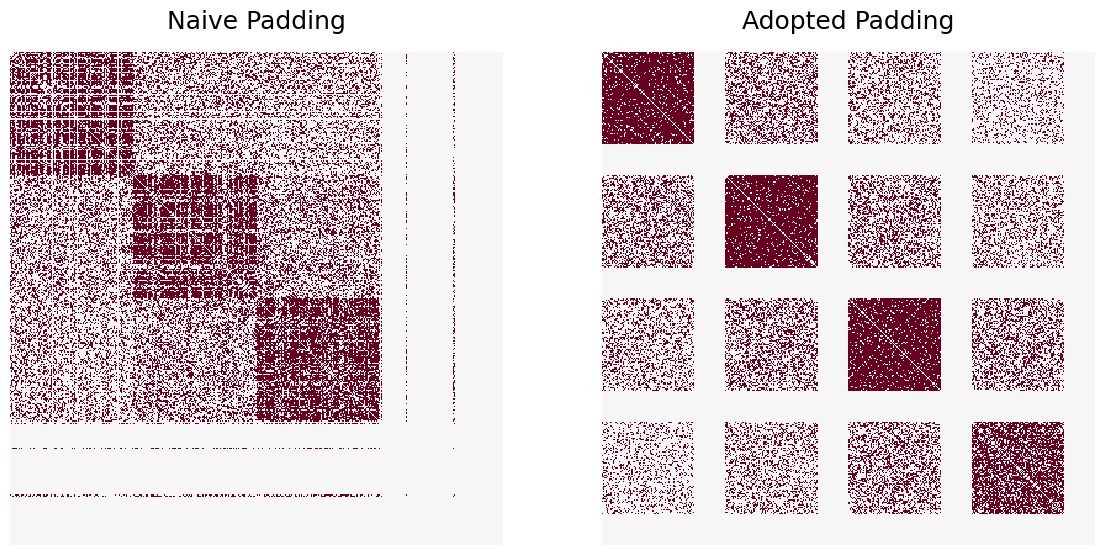

In [2]:
seed2 = rng.choice(np.arange(G2.shape[0]), 8)
seed1 = [int(x / 75) * 25 + x for x in seed2]

partial_match = np.column_stack((seed1, seed2))

naive_indices1, naive_indices2, _, _ = graph_match(
    G1, G2, partial_match=partial_match, padding="naive", rng=rng
)
G2_naive = G2[naive_indices2][:, naive_indices2]
G2_naive_full = np.zeros(G1.shape)
G2_naive_full[np.ix_(naive_indices1, naive_indices1)] = G2_naive

adopted_indices1, adopted_indices2, _, _ = graph_match(
    G1, G2, partial_match=partial_match, padding="adopted", rng=rng
)
G2_adopted = G2[adopted_indices2][:, adopted_indices2]
G2_adopted_full = np.zeros(G1.shape)
G2_adopted_full[np.ix_(adopted_indices1, adopted_indices1)] = G2_adopted

fig, axs = plt.subplots(1, 2, figsize=(14, 7))
heatmap(G2_naive_full, ax=axs[0], cbar=False, title="Naive Padding")
heatmap(G2_adopted_full, ax=axs[1], cbar=False, title="Adopted Padding")


def compute_match_ratio(indices1, indices2):
    match_ratio = 0
    for i in range(len(indices2)):
        if (indices1[i] == keep_indices[i]) and (indices2[i] == i):
            match_ratio += 1
    return match_ratio / len(indices2)

print(f"Matching accuracy with naive padding: {compute_match_ratio(naive_indices1, naive_indices2):.2f}")
print(f"Matching accuracy with adopted padding: {compute_match_ratio(adopted_indices1, adopted_indices2):.2f}")


We observe that the two padding schemes perform as expected. The naive scheme permutes $G_2$ such that it matches a subgraph of $G_1$, specifically the subgraph of the first three blocks. Additionally, (almost) all isolated vertices of $G_2$ are permuted to the fourth block of $G_1$.

On the other hand, we see that adopted padding preserves the common block structure between $G_1$ and $G_2$.